# Cancer Detection with Convolutional Neural Networks

## University of Colorado Boulder
DTSA 5511

Deep Learning

Spring 2024

Anna Sanders

Millions of people develop cancer each year. In most cases, imaging is used to help detect potentially cancerous masses. As more an more people are screened for cancer each year, deep learning and convolutional neural networks can help ease the burden on doctors to correctly identify cancerous masses. Even a 'pre-human' detection program that can classify images and potentially even highlight the potentially cancerous mass can help doctors and practitioners screen even more people for cancer.

In [1]:
import numpy as np
import pandas as pd
import re
import string
from os import listdir

# Plotting Images
import matplotlib.pyplot as plt

# Image Processing
from PIL import Image

# Metrics
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

# Data Exploration

As the data are in an image format (TIF to be exact), we must first create dataset of the transformed image data. 

In [2]:
path_train = '/kaggle/input/histopathologic-cancer-detection/train/'
path_test = '/kaggle/input/histopathologic-cancer-detection/test/'

images_train = [f for f in listdir(path_train)]
images_test= [f for f in listdir(path_test)]

print('Train Images:', len(images_train))
print('Test Images:', len(images_test))
print('Split: %2.f' %(len(images_test)/(len(images_test)+len(images_train))*100),'%')

Train Images: 220025
Test Images: 57458
Split: 21 %


There are 220,025 images in the training set and 57,458 images in the testing set. This results in a 21% train test split.

We can now explore a single image and its characteristics.

TIFF (96, 96) RGB


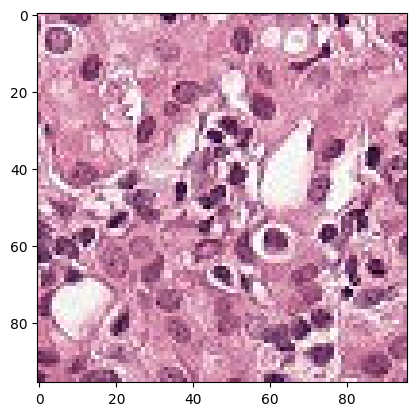

In [3]:
im = Image.open('/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')
print(im.format, im.size, im.mode)
plt.imshow(im)

We can see that this looks like a medical image. I have no medical training, so I cannot comment on exactly what is in the picture, but I can see that there are various different colored circles that could be classified as cancer to a model or unknowledgable person like myself. The image is 96x96 pixels and is in the RGC colorspace.

We can now explore the training labels.

In [4]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels['path'] = train_labels['id'] + '.tif'
train_labels

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,d4b854fe38b07fe2831ad73892b3cec877689576.tif
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,f129691c13433f66e1e0671ff1fe80944816f5a2.tif


The data itself is fairly sparse. It contains the id, which is the file name minus the file format, which is '.tif' and the label itself.

In [5]:
print('Training Label Size:', len(train_labels['id']))
print('Missing Labels:', len(train_labels[train_labels['label'].isna()==True]))
print('Bad Labels:', len(train_labels[(train_labels['label']>1)|(train_labels['label']<0)]))

Training Label Size: 220025
Missing Labels: 0
Bad Labels: 0


([<matplotlib.patches.Wedge at 0x7f502a3ae350>,
 [Text(-0.32334109228524116, 1.051404079333815, '0'),
  Text(0.3233409938456856, -1.0514041096071884, '1')],
 [Text(-0.17636786851922245, 0.5734931341820809, '59.5%'),
  Text(0.1763678148249194, -0.57349315069483, '40.5%')])

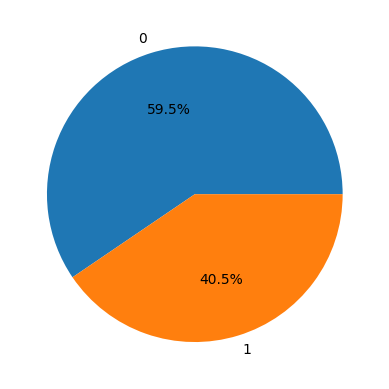

In [6]:
fig, ax = plt.subplots()
df = train_labels['label'].value_counts().reset_index()
df
ax.pie(df['count'], labels=df['label'], autopct='%1.1f%%')

Comparing to the ouputs above, the training labels length matches the total number of training images. There also do not seem to be any missing labels or any bad/incorrect labels. Overall the training data seems to be fairly evenly split between positive and negative instances.

We can now explore some images from each label.

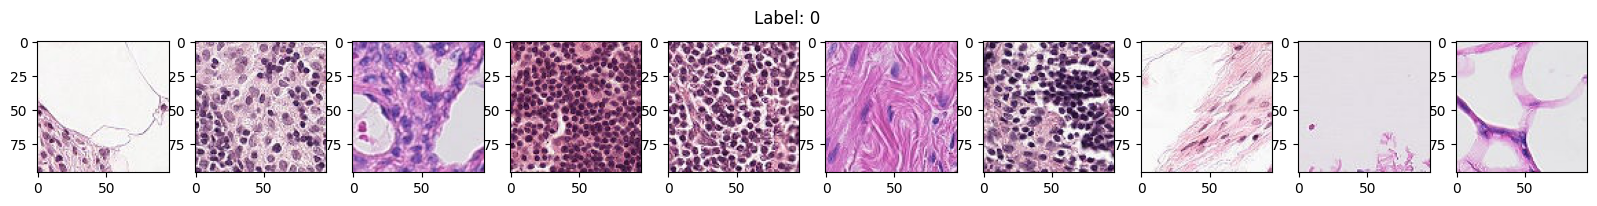

In [7]:
n = 10
label = 0
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = train_labels[train_labels['label']==label].head(n)['path'].values
for i in range(len(df)):
    im = Image.open(path_train+df[i])
    ax[i].imshow(im)
fig.suptitle('Label: '+str(label))
plt.show()

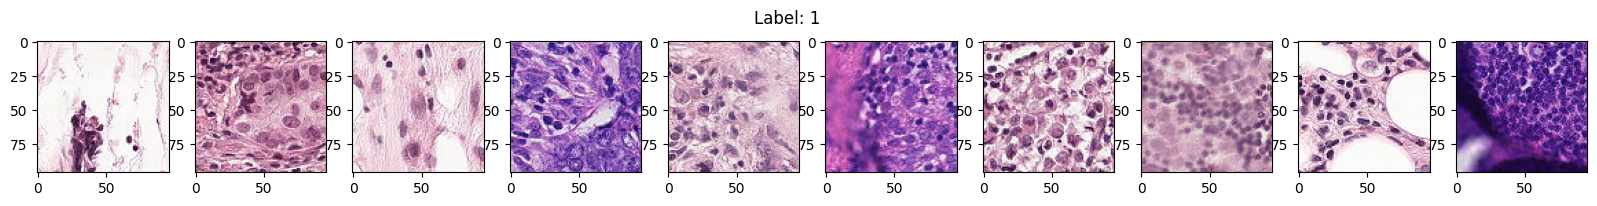

In [8]:
n = 10
label = 1
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = train_labels[train_labels['label']==label].head(n)['path'].values
for i in range(len(df)):
    im = Image.open(path_train+df[i])
    ax[i].imshow(im)
fig.suptitle('Label: '+str(label))
plt.show()

Looking at these two set of images, to an untrained eye, there does not seem to be much that stands out between the two images. It will be interesting to see how well the CNN model does.

## Dataset Creation and Split
We must now create our dataset from the images and labels. We can utilize tensorflow packages to generate the training and test data. Unfortunatly, after repeated testing, there were major performance concerns with using the entire dataset of over 500,000 images. We will instead use a subset of 10,000 images; this allows the ImageDataGenerator functions that create the two subsets and the model training itself faster.

We need to specifically choose the training and validation subsets, as well as specify shuffle = False in order to perform post model fit analysis.

In [30]:
# takes a bit to run
train_labels['label_s'] = train_labels['label'].apply(lambda x: str(x))

batch_size = 100
# data_gen = ImageDataGenerator(rescale=1/255, validation_split =0.15)
data_gen = ImageDataGenerator(rescale=1/255)
training = data_gen.flow_from_dataframe(
    dataframe = train_labels.iloc[0:8500],
    directory = path_train,
    x_col = 'path',
    y_col = 'label_s',
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary', #binary labels need to be strings
    target_size = (96,96),
#     subset = 'training',
    seed = 101,
    validate_filenames = True
)

validation = data_gen.flow_from_dataframe(
    dataframe = train_labels.iloc[8500:10000],
    directory = path_train,
    x_col = 'path',
    y_col = 'label_s',
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary', #binary labels need to be strings
    target_size = (96,96),
#     subset = 'validation',
    seed = 101,
    validate_filenames = True
)

Found 8500 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


## Modeling

We will start with a simple model to train and validate. We can also make sure the size of data used in the training and validation is small enough to use.

In [10]:
# adapted from https://www.tensorflow.org/tutorials/keras/text_classification
def plot_func(history):
    history_dict = history.history
    history_dict.keys()


    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

First few models commented out to improve notebook submission runtime.

In [11]:
# first_model = tf.keras.Sequential([
#     layers.Conv2D(16, kernel_size=(2,2), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
#     layers.Flatten(),
#     layers.Dense(16, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])
# first_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
# first_model.summary()

In [12]:
# history = first_model.fit(x=training, validation_data=validation, epochs=5)

In [13]:
# plot_func(history)

From the above plots, it does look like the model seems to be leveling off, especially when looking at the training accuracy over epochs. We can try building and training a more complex model with more CNN layers.

In [14]:
# second_model = tf.keras.Sequential([
#     layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(4,4), strides=2, padding='same'),
#     layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),
#     layers.Conv2D(32, kernel_size=(2,2), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
#     layers.Flatten(),
#     layers.Dense(16, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])
# second_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
# second_model.summary()

In [15]:
# history = second_model.fit(x=training, validation_data=validation, epochs=5)

In [16]:
# plot_func(history)

This model clearly achieves at a better accuracy after one epoch, but does not seem to dramatically increase the model's validation accuracy. We can try increasing the amount of filters in the CNN layers.

In [17]:
# third_model = tf.keras.Sequential([
#     layers.Conv2D(64, kernel_size=(4,4), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(4,4), strides=2, padding='same'),
#     layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),
#     layers.Conv2D(16, kernel_size=(2,2), padding='same', activation='relu', input_shape=(96,96,3)),
#     layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
#     layers.Flatten(),
#     layers.Dense(16, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])
# third_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
# third_model.summary()

In [18]:
# history = third_model.fit(x=training, validation_data=validation, epochs=10)

In [19]:
# plot_func(history)

This model looks slightly better than the previous model. We'll try one more model with the same number of filters per layer, but kernel sizes all set to (3,3).

In [31]:
fourth_model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
fourth_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
fourth_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 16)       

In [32]:
history = fourth_model.fit(x=training, validation_data=validation, epochs=10)

Epoch 1/10
85/85 [==============================] - 111s 1s/step - loss: 0.6565 - accuracy: 0.6029 - val_loss: 0.6384 - val_accuracy: 0.5960
Epoch 2/10
85/85 [==============================] - 107s 1s/step - loss: 0.5843 - accuracy: 0.6885 - val_loss: 0.5221 - val_accuracy: 0.7700
Epoch 3/10
85/85 [==============================] - 110s 1s/step - loss: 0.4860 - accuracy: 0.7824 - val_loss: 0.4879 - val_accuracy: 0.7607
Epoch 4/10
85/85 [==============================] - 107s 1s/step - loss: 0.4732 - accuracy: 0.7816 - val_loss: 0.4914 - val_accuracy: 0.7667
Epoch 5/10
85/85 [==============================] - 108s 1s/step - loss: 0.4664 - accuracy: 0.7875 - val_loss: 0.4851 - val_accuracy: 0.7640
Epoch 6/10
85/85 [==============================] - 108s 1s/step - loss: 0.4673 - accuracy: 0.7901 - val_loss: 0.4847 - val_accuracy: 0.7633
Epoch 7/10
85/85 [==============================] - 108s 1s/step - loss: 0.4614 - accuracy: 0.7899 - val_loss: 0.4746 - val_accuracy: 0.7760
Epoch 8/10
85

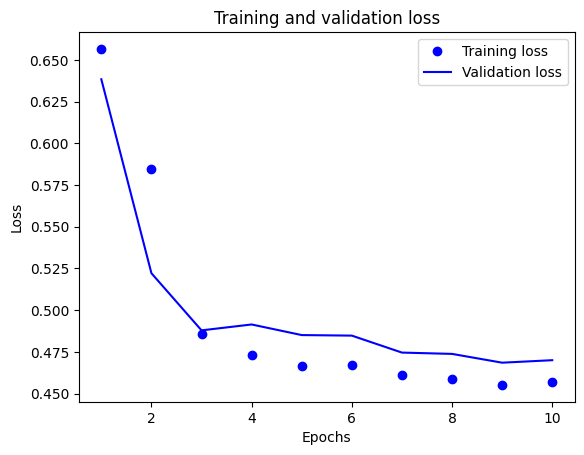

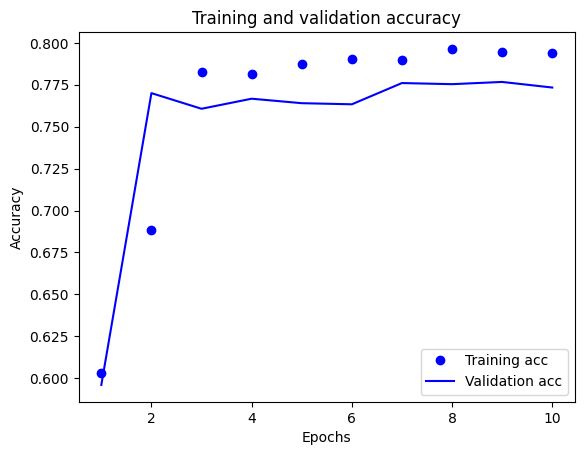

In [33]:
plot_func(history)

Once again, this model is slightly better, but not by much. Due to the time it takes to train these models, we will use the final model above trained on 10 epochs to predict the final test dataset and investigate the validation data.

In [55]:
val_pred = fourth_model.predict(validation)
val_pred

15/15 [==============================] - 5s 309ms/step


array([[0.06299686],
       [0.18402255],
       [0.13164014],
       ...,
       [0.8321301 ],
       [0.5108832 ],
       [0.81643224]], dtype=float32)

We now have to convert these values from probabilities into 1s or 0s.

In [56]:
# val_y_batch = [int(i) for i in val_y_batch]
val_pred = val_pred.reshape(1,-1)[0]
val_pred[val_pred >= 0.5] = '1'
val_pred[val_pred < 0.5] = '0'
print('Lengths:', len(val_pred), len(train_labels.iloc[8500:10000]['label_s'].values))
val_pred

Lengths: 1500 1500


array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [53]:
val_label = train_labels.iloc[8500:10000]['label'].values

Accuracy: 0.77
F1: 0.73
Precision: 0.71
Recall: 0.75


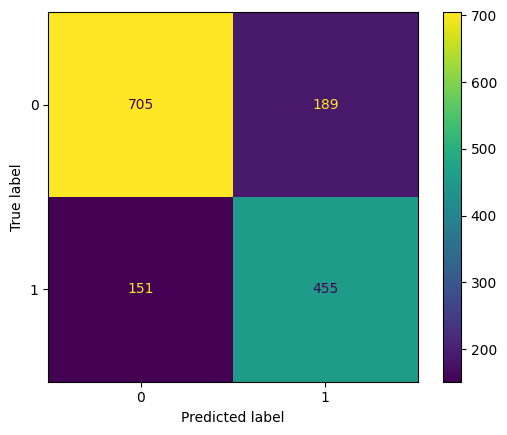

In [54]:
cm = confusion_matrix(val_label, val_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
print('Accuracy: %.2f' %(accuracy_score(val_label, val_pred)))
print('F1: %.2f' %(f1_score(val_label, val_pred)))
print('Precision: %.2f' %(precision_score(val_label, val_pred)))
print('Recall: %.2f' %(recall_score(val_label, val_pred)))

Looking at the confusion matrix, the model predicts fairly well. Fortunatly, it does worse predicting cancer when there is none than predicting no cancer where there is cancer, although both situations are not ideal.

We can now predict the test images and submit tot he Kaggle competiton.

In [64]:
test_df = pd.DataFrame(images_test, columns=['path'])
test_df['id'] = test_df['path'].apply(lambda x: x.replace('.tif',''))

In [69]:
test = data_gen.flow_from_dataframe(
    dataframe = test_df,
    directory = path_test,
    x_col = 'path',
    shuffle = False,
    target_size = (96,96),
    class_mode=None, #testing df
    classes=None,
    validate_filenames = True
)

Found 57458 validated image filenames.


In [71]:
test_pred = fourth_model.predict(test)

1796/1796 [==============================] - 183s 102ms/step


In [72]:
test_pred = test_pred.reshape(1,-1)[0]
test_pred[test_pred >= 0.5] = '1'
test_pred[test_pred < 0.5] = '0'
print('Lengths:', len(test_pred), len(test_df))

Lengths: 57458 57458


In [76]:
test_df['label'] = test_pred
test_df['label'] = test_df['label'].astype(int)
test_df[['id','label']]

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,1
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0


In [77]:
test_df[['id','label']].to_csv('submission.csv', index=False)

# Conclusions

The final submission to this project had an accuracy of 0.724, which was below the final validation's model accuracy of 0.77. There are two specific ways that the final model could be improved: training on more images and manipulating the trained (and validated) images. Due to time and processing limiations, the model was only trained on the first 10,000 images. This is a lot of images, but was only 4.5% of the overall training image data. Similarly, the 10,000 images trained on was also less than the testing dataset. There are likely improvements to be made in the modeling if more images are included. Similarly, the method used to load images into the training dataframe allowed for manipulation of the images, which includes rotating and resizing. This can help the model not overfit to certain types of images, which could be helpful in the modeling process.

Overall, I think this model did well for the amount of images beign used to train and the lack of training image manipulation.

![](cancer-detection-cnn_screenshot.png)

# References
- https://pillow.readthedocs.io/en/stable/handbook/tutorial.html
- https://www.tensorflow.org/guide/data
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://www.kaggle.com/code/rodrigolealtarrago/notebook2ea1998649